In [2]:
# Standard packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os.path import join
import os
import glob
import json
import sys

# Progress bar
from tqdm import tqdm

# Torch core
import torch
print("Torch version:", torch.__version__)
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.nn.functional import relu
from torch import optim
import torch.nn.functional as F

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# DeepLabV3 and other segmentation models
import segmentation_models_pytorch as smp

# (Optional) Set up matplotlib display for Jupyter
%matplotlib inline
import matplotlib.pylab as pt


Torch version: 2.7.0+cu126


In [3]:
root_path = 'a2d2-dataset/camera_lidar_semantic'
# get the list of files in lidar directory
file_names = sorted(glob.glob(join(root_path, '*/camera/cam_front_center/*.png')))

# select the lidar point cloud
test_file_name = file_names[5]

In [4]:
test_file_name

'a2d2-dataset/camera_lidar_semantic/20180807_145028/camera/cam_front_center/20180807145028_camera_frontcenter_000000544.png'

In [5]:
len(file_names)

31448

In [6]:
def extract_image_file_name(file_name):
    file_name_image = file_name.split('/')
    file_name_image = file_name_image[-1].split('.')[0]
    file_name_image = file_name_image.split('_')
    file_name_image = file_name_image[0] + '_' + \
                        'camera_' + \
                        file_name_image[2] + '_' + \
                        file_name_image[3] + '.png'

    return file_name_image

In [7]:
seq_name = test_file_name.split('/')[2]
print('Seq name: ', seq_name)
file_name_image = extract_image_file_name(test_file_name)
print('File name image: ', file_name_image)
file_name_image = join(root_path, seq_name, 'camera/cam_front_center/', file_name_image)
print('Full image file name: ', file_name_image)
image_front_center = cv2.imread(file_name_image)

Seq name:  20180807_145028
File name image:  20180807145028_camera_frontcenter_000000544.png
Full image file name:  a2d2-dataset/camera_lidar_semantic/20180807_145028/camera/cam_front_center/20180807145028_camera_frontcenter_000000544.png


In [8]:
image_front_center = cv2.cvtColor(image_front_center, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'front center')

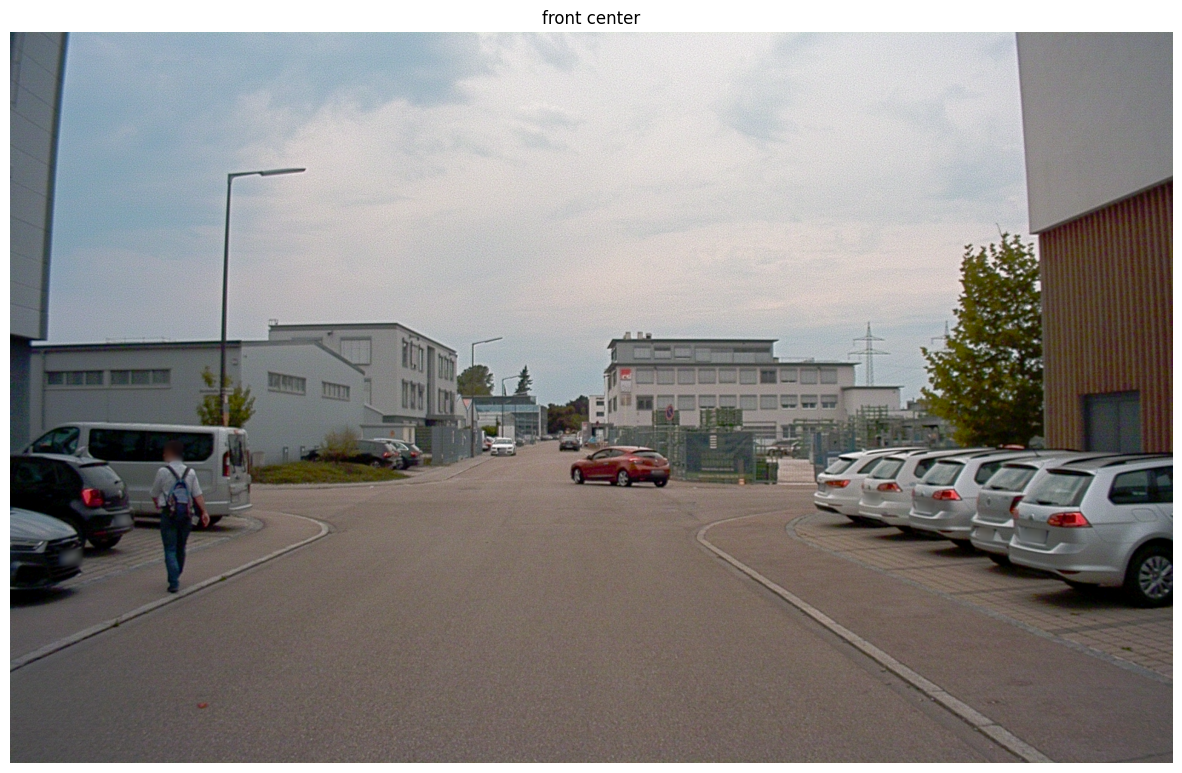

In [9]:
pt.fig = pt.figure(figsize=(15, 15))

# display image from front center camera
pt.imshow(image_front_center)
pt.axis('off')
pt.title('front center')

In [10]:
def extract_semantic_file_name_from_image_file_name(file_name_image):
    file_name_semantic_label = file_name_image.split('/')
    file_name_semantic_label = file_name_semantic_label[-1].split('.')[0]
    file_name_semantic_label = file_name_semantic_label.split('_')
    file_name_semantic_label = file_name_semantic_label[0] + '_' + \
                  'label_' + \
                  file_name_semantic_label[2] + '_' + \
                  file_name_semantic_label[3] + '.png'
    
    return file_name_semantic_label

In [11]:
seq_name = test_file_name.split('/')[2]
print('Seq: ', seq_name)
file_name_semantic_label = extract_semantic_file_name_from_image_file_name(file_name_image)
print('Semantic label file name: ', file_name_semantic_label)
file_name_semantic_label = join(root_path, seq_name, 'label/cam_front_center/', file_name_semantic_label)
print('Full semantic label file path: ', file_name_semantic_label)
semantic_image_front_center = cv2.imread(file_name_semantic_label)

Seq:  20180807_145028
Semantic label file name:  20180807145028_label_frontcenter_000000544.png
Full semantic label file path:  a2d2-dataset/camera_lidar_semantic/20180807_145028/label/cam_front_center/20180807145028_label_frontcenter_000000544.png


In [12]:
semantic_image_front_center = cv2.cvtColor(semantic_image_front_center, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'label front center')

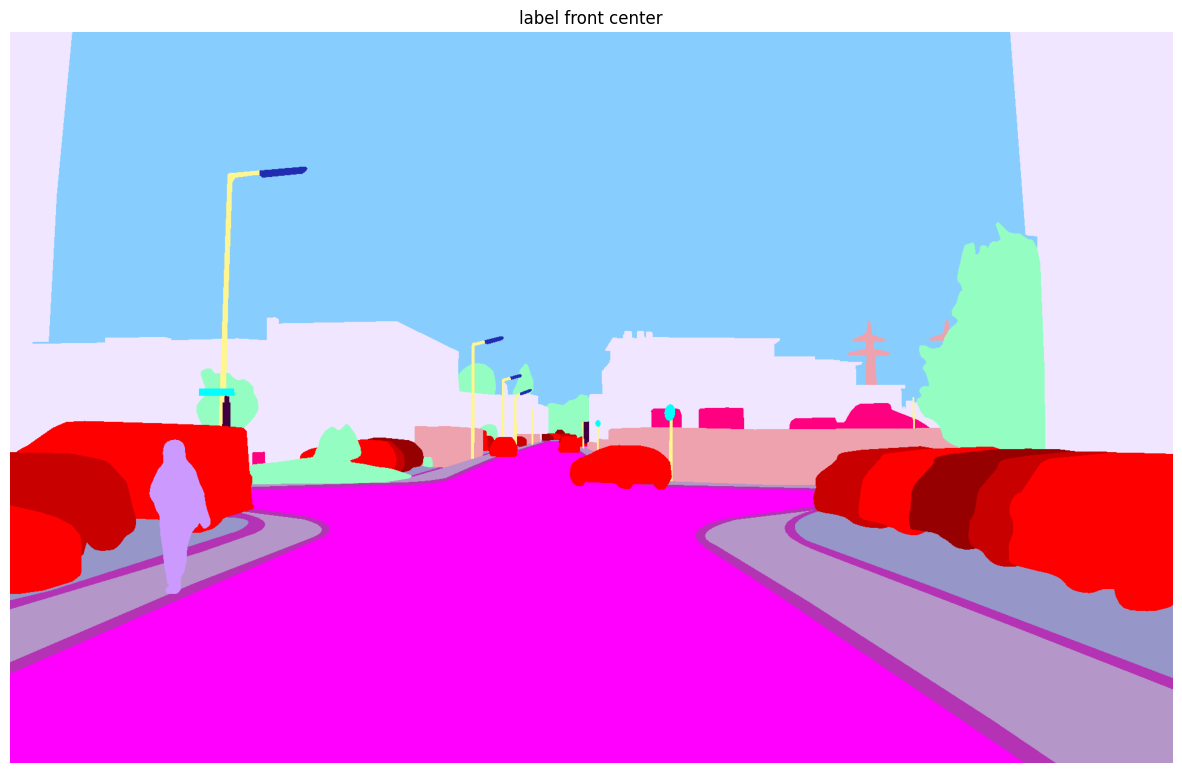

In [13]:
pt.fig = pt.figure(figsize=(15, 15))
pt.imshow(semantic_image_front_center)
pt.axis('off')
pt.title('label front center')

In [14]:
with open('a2d2-dataset/camera_lidar_semantic/class_list.json', 'r') as f:
    classes = json.load(f)

In [15]:
classes

{'#ff0000': 'Car 1',
 '#c80000': 'Car 2',
 '#960000': 'Car 3',
 '#800000': 'Car 4',
 '#b65906': 'Bicycle 1',
 '#963204': 'Bicycle 2',
 '#5a1e01': 'Bicycle 3',
 '#5a1e1e': 'Bicycle 4',
 '#cc99ff': 'Pedestrian 1',
 '#bd499b': 'Pedestrian 2',
 '#ef59bf': 'Pedestrian 3',
 '#ff8000': 'Truck 1',
 '#c88000': 'Truck 2',
 '#968000': 'Truck 3',
 '#00ff00': 'Small vehicles 1',
 '#00c800': 'Small vehicles 2',
 '#009600': 'Small vehicles 3',
 '#0080ff': 'Traffic signal 1',
 '#1e1c9e': 'Traffic signal 2',
 '#3c1c64': 'Traffic signal 3',
 '#00ffff': 'Traffic sign 1',
 '#1edcdc': 'Traffic sign 2',
 '#3c9dc7': 'Traffic sign 3',
 '#ffff00': 'Utility vehicle 1',
 '#ffffc8': 'Utility vehicle 2',
 '#e96400': 'Sidebars',
 '#6e6e00': 'Speed bumper',
 '#808000': 'Curbstone',
 '#ffc125': 'Solid line',
 '#400040': 'Irrelevant signs',
 '#b97a57': 'Road blocks',
 '#000064': 'Tractor',
 '#8b636c': 'Non-drivable street',
 '#d23273': 'Zebra crossing',
 '#ff0080': 'Obstacles / trash',
 '#fff68f': 'Poles',
 '#960096':

Create a dataset with images and corresponding masks

In [16]:
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

In [17]:
COLOR_TO_CLASS = {}
for idx, (hex_color, class_name) in enumerate(classes.items()):
    rgb = hex_to_rgb(hex_color)
    COLOR_TO_CLASS[idx] = rgb

In [18]:
COLOR_TO_CLASS

{0: (255, 0, 0),
 1: (200, 0, 0),
 2: (150, 0, 0),
 3: (128, 0, 0),
 4: (182, 89, 6),
 5: (150, 50, 4),
 6: (90, 30, 1),
 7: (90, 30, 30),
 8: (204, 153, 255),
 9: (189, 73, 155),
 10: (239, 89, 191),
 11: (255, 128, 0),
 12: (200, 128, 0),
 13: (150, 128, 0),
 14: (0, 255, 0),
 15: (0, 200, 0),
 16: (0, 150, 0),
 17: (0, 128, 255),
 18: (30, 28, 158),
 19: (60, 28, 100),
 20: (0, 255, 255),
 21: (30, 220, 220),
 22: (60, 157, 199),
 23: (255, 255, 0),
 24: (255, 255, 200),
 25: (233, 100, 0),
 26: (110, 110, 0),
 27: (128, 128, 0),
 28: (255, 193, 37),
 29: (64, 0, 64),
 30: (185, 122, 87),
 31: (0, 0, 100),
 32: (139, 99, 108),
 33: (210, 50, 115),
 34: (255, 0, 128),
 35: (255, 246, 143),
 36: (150, 0, 150),
 37: (204, 255, 153),
 38: (238, 162, 173),
 39: (33, 44, 177),
 40: (180, 50, 180),
 41: (255, 70, 185),
 42: (238, 233, 191),
 43: (147, 253, 194),
 44: (150, 150, 200),
 45: (180, 150, 200),
 46: (72, 209, 204),
 47: (200, 125, 210),
 48: (159, 121, 238),
 49: (128, 0, 255),


In [19]:
def rgb_to_class(mask_rgb, color_to_class):
    h, w, _ = mask_rgb.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)
    color_to_id = {v: k for k, v in color_to_class.items()}
    mask_flat = mask_rgb.reshape(-1, 3)
    class_mask_flat = np.zeros(mask_flat.shape[0], dtype=np.uint8)
    for color, class_id in color_to_id.items():
        matches = np.all(mask_flat == color, axis=1)
        class_mask_flat[matches] = class_id
    return class_mask_flat.reshape(h, w)

In [20]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, file_names, root_path, transform=None, patch_size=None, random_crop=True):
        self.file_names = file_names
        self.root_path = root_path
        self.transform = transform
        self.patch_size = patch_size
        self.random_crop = random_crop

    def extract_image_file_name(self, file_name):
        file_name_image = file_name.split('/')
        file_name_image = file_name_image[-1].split('.')[0]
        file_name_image = file_name_image.split('_')
        file_name_image = file_name_image[0] + '_' + \
                        'camera_' + \
                        file_name_image[2] + '_' + \
                        file_name_image[3] + '.png'

        return file_name_image

    def extract_semantic_file_name_from_image_file_name(self, file_name_image):
        file_name_semantic_label = file_name_image.split('/')
        file_name_semantic_label = file_name_semantic_label[-1].split('.')[0]
        file_name_semantic_label = file_name_semantic_label.split('_')
        file_name_semantic_label = file_name_semantic_label[0] + '_' + \
                  'label_' + \
                  file_name_semantic_label[2] + '_' + \
                  file_name_semantic_label[3] + '.png'
    
        return file_name_semantic_label

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        
        seq_name = file_name.split('/')[2]
        
        # Image path
        file_name_image = self.extract_image_file_name(file_name)
        file_name_image = join(self.root_path, seq_name, 'camera/cam_front_center', file_name_image)
        image_front_center = cv2.imread(file_name_image)
        image_front_center = cv2.cvtColor(image_front_center, cv2.COLOR_BGR2RGB)

        # Semantic mask path
        file_name_semantic_label = self.extract_semantic_file_name_from_image_file_name(file_name_image)
        file_name_semantic_label = join(self.root_path, seq_name, 'label/cam_front_center', os.path.basename(file_name_semantic_label))
        semantic_image_front_center = cv2.imread(file_name_semantic_label)
        semantic_image_front_center = cv2.cvtColor(semantic_image_front_center, cv2.COLOR_BGR2RGB)
        
        mask = rgb_to_class(semantic_image_front_center, COLOR_TO_CLASS)
        
        # Normalize image
        image_front_center = image_front_center.astype(np.float32) / 255.0
        
        if self.patch_size is not None:
            h, w, _ = image_front_center.shape
            ph, pw = self.patch_size

            if h < ph or w < pw:
                raise ValueError(f"Patch size {self.patch_size} is too big for image of size ({h}, {w})")

            if self.random_crop:
                top = np.random.randint(0, h - ph + 1)
                left = np.random.randint(0, w - pw + 1)
            else:
                top = (h - ph) // 2
                left = (w - pw) // 2

            image_front_center = image_front_center[top:top+ph, left:left+pw, :]
            mask = mask[top:top+ph, left:left+pw]

        if self.transform:
            augmented = self.transform(image=image_front_center, mask=mask)
            image_front_center = augmented['image']
            mask = augmented['mask']

        # Convert to torch tensors
        image_tensor = torch.tensor(image_front_center.transpose(2, 0, 1), dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.long)

        return image_tensor, mask_tensor

In [21]:
def plot_full_image_and_mask(dataset, idx=0):
    image_tensor, mask_tensor = dataset[idx]
    
    # Convert image and mask to numpy for plotting
    image_np = image_tensor.permute(1, 2, 0).numpy()
    mask_np = mask_tensor.numpy()

    # Plot
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Full Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap="nipy_spectral")
    plt.title("Semantic Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [22]:
def plot_patch_image_and_mask(dataset, num_samples=4):
    plt.figure(figsize=(12, 3 * num_samples))
    
    for i in range(num_samples):
        image_tensor, mask_tensor = dataset[i]
        
        # Convert tensors to NumPy arrays for plotting
        image_np = image_tensor.permute(1, 2, 0).numpy()
        mask_np = mask_tensor.numpy()

        # Plot image
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image_np)
        plt.title(f'Image Patch {i}')
        plt.axis('off')

        # Plot mask
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask_np, cmap='nipy_spectral')
        plt.title(f'Mask Patch {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

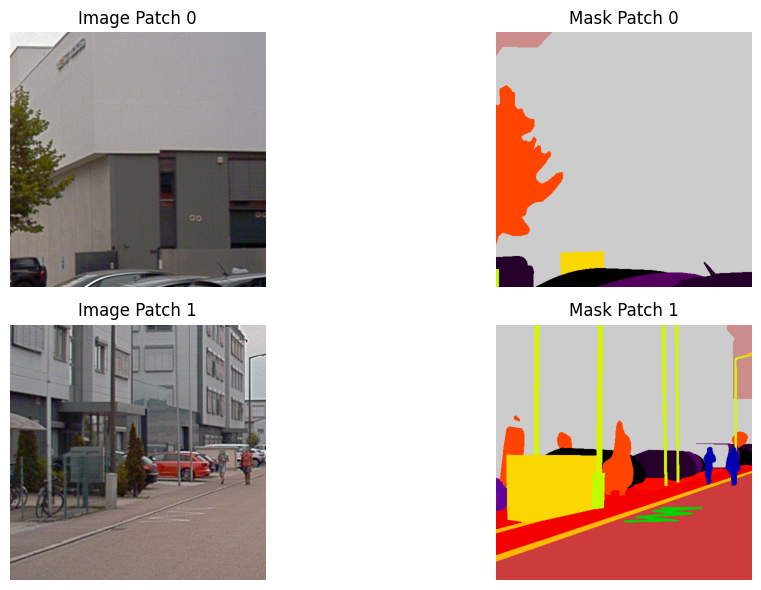

In [23]:
patch_dataset = SemanticSegmentationDataset(file_names=file_names[:200], root_path=root_path, transform=None, patch_size=(512,512))

plot_patch_image_and_mask(patch_dataset, num_samples=2)

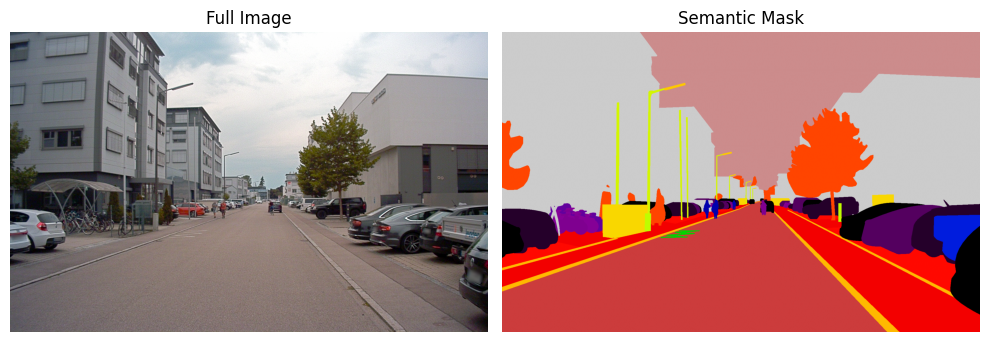

In [24]:
full_dataset = SemanticSegmentationDataset(file_names=file_names[:200], root_path=root_path, transform=None, random_crop=False)
plot_full_image_and_mask(full_dataset)

In [25]:
sample_img, sample_mask = patch_dataset[0]
print("Image shape:", sample_img.shape)   # Should be [3, H, W]
print("Mask shape:", sample_mask.shape)   # Should be [H, W]
print("Unique class IDs:", torch.unique(sample_mask))  # Should be in range [0, NUM_CLASSES-1]


Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])
Unique class IDs: tensor([ 0,  1,  2,  3,  4,  8, 28, 34, 35, 38, 39, 40, 43, 44, 45, 50, 51, 52])


In [26]:
import segmentation_models_pytorch as smp

NUM_CLASSES = len(COLOR_TO_CLASS)

model = smp.DeepLabV3(
    encoder_name="resnet34",           # you can try 'mobilenet_v2' later
    encoder_weights="imagenet",        # use pretrained encoder
    in_channels=3,                     # RGB
    classes=NUM_CLASSES,               # based on your mapping
    decoder_use_batchnorm=True
)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [28]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [29]:
from torch.utils.data import DataLoader

train_loader = DataLoader(patch_dataset, batch_size=4, shuffle=True)

In [30]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch, total_epochs):
    model.train()
    epoch_loss = 0.0

    all_preds = []
    all_targets = []

    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{total_epochs}]")
    
    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record loss
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        # For metrics
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_targets.extend(masks.cpu().numpy().flatten())

    # Metrics
    avg_loss = epoch_loss / len(dataloader)
    acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    print(f"\nEpoch [{epoch+1}] Summary:")
    print(f"Loss: {avg_loss:.4f} | Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, f'deeplab_checkpoint_epoch{epoch+1}.pth')

    return avg_loss, acc, precision, recall, f1


In [ ]:
NUM_EPOCHS = 25  # Set how many epochs you want

for epoch in range(NUM_EPOCHS):
    train_one_epoch(model, train_loader, optimizer, criterion, device, epoch, NUM_EPOCHS)


Epoch [1/25]: 100%|██████████| 50/50 [12:11<00:00, 14.64s/it, loss=1.34]



Epoch [1] Summary:
Loss: 2.1834 | Acc: 0.6560 | Precision: 0.0612 | Recall: 0.0591 | F1: 0.0540


Epoch [2/25]: 100%|██████████| 50/50 [11:27<00:00, 13.75s/it, loss=1.49] 



Epoch [2] Summary:
Loss: 1.3223 | Acc: 0.7882 | Precision: 0.0899 | Recall: 0.1024 | F1: 0.0929


Epoch [3/25]: 100%|██████████| 50/50 [10:58<00:00, 13.16s/it, loss=1.48] 



Epoch [3] Summary:
Loss: 1.0998 | Acc: 0.7957 | Precision: 0.1376 | Recall: 0.1169 | F1: 0.1083


Epoch [4/25]: 100%|██████████| 50/50 [11:04<00:00, 13.30s/it, loss=1.55] 



Epoch [4] Summary:
Loss: 0.9140 | Acc: 0.8232 | Precision: 0.1512 | Recall: 0.1338 | F1: 0.1284


Epoch [5/25]: 100%|██████████| 50/50 [10:49<00:00, 13.00s/it, loss=0.691]



Epoch [5] Summary:
Loss: 0.8000 | Acc: 0.8301 | Precision: 0.2038 | Recall: 0.1430 | F1: 0.1395


Epoch [6/25]: 100%|██████████| 50/50 [10:48<00:00, 12.98s/it, loss=0.768]



Epoch [6] Summary:
Loss: 0.6607 | Acc: 0.8601 | Precision: 0.1949 | Recall: 0.1532 | F1: 0.1505


Epoch [7/25]: 100%|██████████| 50/50 [10:49<00:00, 12.99s/it, loss=0.576]



Epoch [7] Summary:
Loss: 0.6131 | Acc: 0.8638 | Precision: 0.2192 | Recall: 0.1674 | F1: 0.1638


Epoch [8/25]: 100%|██████████| 50/50 [10:49<00:00, 12.99s/it, loss=0.417]



Epoch [8] Summary:
Loss: 0.5925 | Acc: 0.8601 | Precision: 0.2051 | Recall: 0.1742 | F1: 0.1758


Epoch [9/25]:  76%|███████▌  | 38/50 [08:11<02:37, 13.12s/it, loss=0.905]

In [ ]:
import torch
import segmentation_models_pytorch as smp

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model architecture (must match saved model)
NUM_CLASSES = len(COLOR_TO_CLASS)  # use your own COLOR_TO_CLASS mapping
model = smp.DeepLabV3(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    decoder_use_batchnorm=True
)
model = model.to(device)


In [39]:

# Load checkpoint
checkpoint_path = "deeplab_checkpoint_epoch8.pth" 
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # important for inference

print(f"Model loaded from: {checkpoint_path}")


Model loaded from: deeplab_checkpoint_epoch8.pth


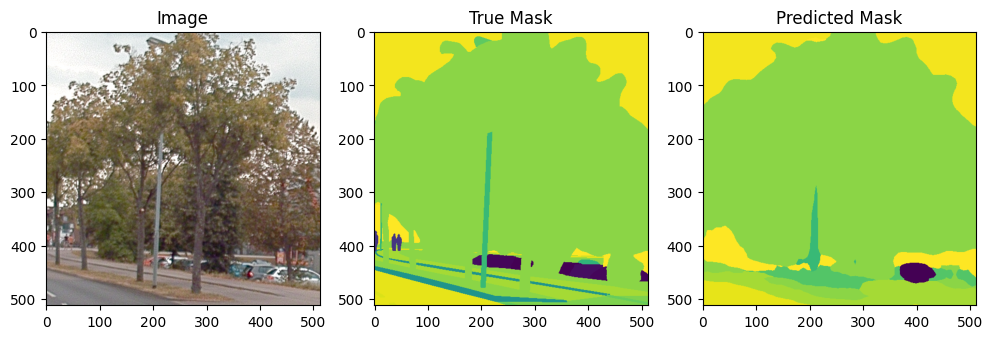

In [41]:
import matplotlib.pyplot as plt

model.eval()
sample_img, sample_mask = patch_dataset[89]
with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(device))
    pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(sample_img.permute(1,2,0)); plt.title("Image")
plt.subplot(1, 3, 2); plt.imshow(sample_mask); plt.title("True Mask")
plt.subplot(1, 3, 3); plt.imshow(pred_mask); plt.title("Predicted Mask")
plt.show()


Total unused files: 31248
Picked test image: a2d2-dataset/camera_lidar_semantic/20180925_135056/camera/cam_front_center/20180925135056_camera_frontcenter_000055060.png


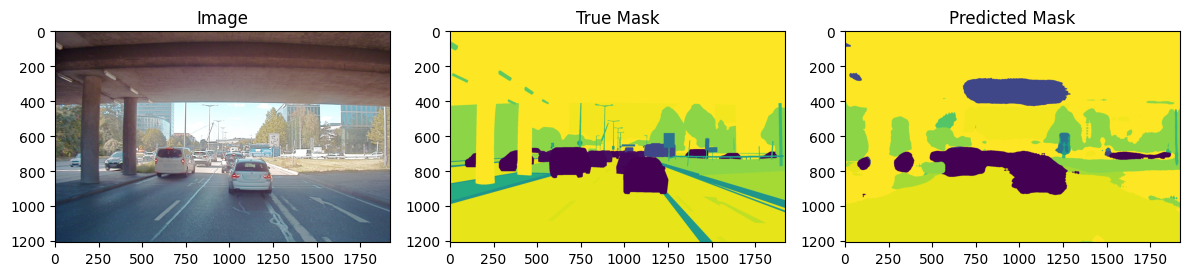

In [42]:
from glob import glob
import random

# All front camera image files in dataset
all_img_files = sorted(glob("a2d2-dataset/camera_lidar_semantic/*/camera/cam_front_center/*.png"))

# Training files (from patch_dataset)
train_img_files = patch_dataset.file_names

# Get unused files
unused_files = sorted(list(set(all_img_files) - set(train_img_files)))
print(f"Total unused files: {len(unused_files)}")

# Pick one randomly
test_file = random.choice(unused_files)
print("Picked test image:", test_file)

# Create test dataset
test_ds = SemanticSegmentationDataset(
    file_names=[test_file],
    root_path="a2d2-dataset/camera_lidar_semantic",
    patch_size=None,
    random_crop=False
)

# Run model
test_img, test_mask = test_ds[0]
model.eval()
with torch.no_grad():
    pred_mask = torch.argmax(model(test_img.unsqueeze(0).to(device)).squeeze(), dim=0).cpu().numpy()

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(test_img.permute(1, 2, 0)); plt.title("Image")
plt.subplot(1, 3, 2); plt.imshow(test_mask); plt.title("True Mask")
plt.subplot(1, 3, 3); plt.imshow(pred_mask); plt.title("Predicted Mask")
plt.tight_layout(); plt.show()
